# Can student enrollment data affect stock price prediction of for-profit education companies?
###### Final Capstone - Jason Paik

### Introduction 
One of my biggest passions in life is education. It is often something I take for granted knowing that I wouldn’t be the person I am today without it and simultaneously in the world of education, it’s a pillar in the local community living in Philadelphia that I hope to strive to build in my career and give back to education as much as I can.

As a member of a school board for a private K-8 school in North Philadelphia, as a board, we’ve entered into countless hours of conversations about the stigmas of for-profit education institutions and what really drives these preconceived biases we’ve had about these publicly traded companies. And now currently we field deep interest from graduating students entering into secondary high schools about cyber/online-based high schools, some of them which are even curious to pursue further towards applying to for-profit universities. I sat back thinking, “Wait, are those for-profit schools’ advertisements late at night actually legitimate? Do students actually go to those?” And in embarrassing confessions, it is truly a misconceived bias we're slowly beginning to collectively reconcile as a board! But through this data science program, it was always in my mind to consider how I can leverage my data science skill set towards understanding this stigma, seeing if it is successful, and whether I could build a tool to predict for profit education company success as a company traded on the stock exchange.
 
For my capstone – without any data wrangling or research – my hypothesis was that enrollment data must have had a positive effect on the “success” of an education company's stock. I wanted to leverage this capstone to (1) see if this preconceived notion was true and (2) if it was, could we predict the price of a stock if we were to predict enrollment? Many of the time series topics we covered in the previous unit (ARIMA) was univariate and future-looking projections were based on a single variable’s historic performance. But if we could take a multivariate approach and see if we could have multiple inputs towards our future-looking projection of a stock price, could we come with closer accuracy? 

The data product I hope to develop is a stock prediction model that uses non-stock data as features to directly shape the y-variable (stock price) depending whether or not the variables were properly correlated or not. This type of product can be leveraged into a tool that can practically apply in real business settings, hopefully to not just those working in the investment world to model trades and share price predictions, but towards education companies themselves. As a for-profit university if I could track with my internal, proprietary data that is not publicly disseminated, this model can be robust to predict other features that might be beneficial towards the success of the institution.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn
import scipy.stats as stats
import seaborn as sns
import datetime 
import statsmodels
import statsmodels.api as sm
import matplotlib
import quandl
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.vector_ar.var_model import VAR

Using TensorFlow backend.


### *Data Sources*

#### K-12 and Grand Canyon University

The two companies I focused my capstone on was K-12 and Grand Canyon University (GCU). K-12 is online secondary education high school that leverages online course material l as a way for students to remotely attend classes and graduate remotely via video conferencing and their proprietary online framework. Through their network of teachers who work remotely to teach their online classrooms, K-12 is recognized as one of the biggest names in education-tech that are uniquely leveraging the cyber classroom to graduate students.

Alternatively, Grand Canyon University is recognized as one of the biggest for-profit universities in America. The university has attracted students of wide age ranges because of its unique technology platform  to achieve collegiate-level accreditations for a wide-ranging number of degrees all remotely through a computer. Its popularity is vast amongst all demographics and is nationally recognized as a leading for-profit educational institution in the United States.
 
Both academic institutions are publicly-traded on the stock exchange and thus their public data was sourced manually through their investor notices and 10K Annual Reports. I sifted through 10 years of annual reporting to find as much enrollment data I could respectively of each company and created a dataframe to reflect this. I arbitrarily assigned September dates as the “beginning” of their year, given the academic calendar starts in September, but had to manually align the dates to match business days so stock price data could properly be "joined" as a single, combined dataframe (because the stock exchange does not trade on the weekends and sometimes a 9/1 date could fall on a weekend date).

In [2]:
## This data originates from the 10K Annual Reporting filings by K12 and Grand Canyon University.
## The dates are marked with arbitrary September dates (marking beginning of school year) and they are all not
## marked on the 9/1 because we want to do an INNER JOIN on the stock data against the date. Consequentially
## you will have September dates that fall on the weekend where the stock markets are closed so it is imperative
## we find business days, excluding as well Labor Day, that align with a trade date.
K12Enroll = {'Date': ['09/01/2007','09/01/2008','09/01/2009','09/01/2010','09/01/2011','09/07/2012'
                      ,'09/06/2013','09/05/2014','09/01/2015','09/01/2016','09/27/2017','09/04/2018'],
            'Enrollment': ['27005','40859','54962','56962','71322','100686','117563','123259','120257','102935','103964','108740']
            }
K12_df = pd.DataFrame(K12Enroll, columns = ['Date','Enrollment'])
GCUEnroll = {'Date': ['09/01/2008','09/01/2009','09/01/2010','09/01/2011','09/07/2012'
                      ,'09/06/2013','09/05/2014','09/01/2015','09/01/2016','09/27/2017','09/04/2018'],
            'Enrollment': ['24636','37709','41482','43917','52292','59658','67806','74506','81908','90297','97369']
            }
GCU_df = pd.DataFrame(GCUEnroll, columns = ['Date','Enrollment'])
K12_df['Date'] = pd.to_datetime(K12_df['Date'])
GCU_df['Date'] = pd.to_datetime(GCU_df['Date'])
K12_df['Enrollment'] = K12_df.Enrollment.astype(float)
GCU_df['Enrollment'] = GCU_df.Enrollment.astype(float)

#### NASDAQ

On the NASDAQ website, company stock price data is found going as far back as 10 years. Initially I wanted to hone in on other finance metrics such as revenue, expense ratios, and other profitability measures, but the finance statistics on NASDAQ only hone in on daily prices of the stock (open, close, high, low) and the volume of transactions per day. The daily price of the stock between the four classifiers are pretty similar but the volume of transactions fluctuate quite deeply depending on activity that day or any information that's publicly disseminated that would lead to a massive selling or buying of stock.

In [3]:
NSCH_datapath = ("https://raw.githubusercontent.com/theloyal6er/FinalCapstone/master/NSCH_Enrollment.csv")
NSCHEnrollment = pd.read_csv(NSCH_datapath)
NSCHEnrollment['Date'] = pd.to_datetime(NSCHEnrollment.Date)
GCU_datapath = ("https://raw.githubusercontent.com/theloyal6er/FinalCapstone/master/GrandCanyon_10yr.csv")
K12_datapath = ("https://raw.githubusercontent.com/theloyal6er/FinalCapstone/master/K12_10yr.csv")
GCUprice = pd.read_csv(GCU_datapath)
K12price = pd.read_csv(K12_datapath)

In [4]:
GCUfinance = GCUprice
GCUfinance = GCUfinance.drop(GCUfinance.index[0])

In [5]:
GCUfinance['date'] = pd.to_datetime(GCUfinance.date)
GCUfinance['volume'] = GCUfinance.volume.astype(float)

In [6]:
K12finance = K12price
K12finance = K12finance.drop(K12finance.index[0])

In [7]:
K12finance['date'] = pd.to_datetime(K12finance.date)
K12finance['volume'] = K12finance.volume.astype(float)

#### National Student ClearingHouse Research Center
 
National Student ClearingHouse Research Center is a national, non-profit education partner center that works with higher education institutions, states, districts, high schools, and educational organizations to better inform practitioners and policymakers about student education. On their website, I sifted through ten years of data across fall and spring annual reports back since 2009 and looked at the total enrollment of tertiary (collegiate-level of academia) students in America. NSCH data is widely attributed as a credible source of national educational data and the data I saw here – separate from enrollment data of K12 and GCU – was extracted to see how tertiary enrollment data nationally affected stock price and whether (1) investors were concerned or affected by these statistics and (2) if it played a part in their investor sentiment in purchasing for profit education stocks.

In [8]:
## Establish the dataframe for stock prices
GCUdf = GCUprice[['date','close']]
K12df = K12price[['date','close']]
GCUdf = GCUdf.rename(columns = {"date":"Date","close":"close_GCU"})
K12df = K12df.rename(columns = {"date":"Date","close":"close_K12"})
GCUdf['Date'] = pd.to_datetime(GCUdf.Date)
K12df['Date'] = pd.to_datetime(K12df.Date)
GCUdf = GCUdf.sort_values(by=['Date'])
K12df = K12df.sort_values(by=['Date'])

In [9]:
stockTertiarydf = GCUdf.merge(K12df,on = 'Date', how='inner').merge(NSCHEnrollment, on = 'Date', how='inner')

#### QUANDL (World Bank of Education Statistics)

QUANDL is an online platform that hosts wide ranges of data in easily readable Python formats through a package and authentication tokens. Within QUANDL, I looked at the World Bank of Education Statistics to see the tertiary student enrollment and tertiary graduate data. The data is similar to NSCH but as a part of validating the trends, I wanted honed in on the World Bank of Education Statistics to particular look at secondary education enrollment and how it specifically correlates with the K12 stock.

In [10]:
## Use the QUANDL python package to retrieve data from the QUANDL site
tertGrads = quandl.get("WEDU/USA_SE_TER_GRAD", authtoken="zdw7NQYFYvGVdBjHbbuH")
tertEnroll = quandl.get("WEDU/USA_SE_TER_ENRL", authtoken="zdw7NQYFYvGVdBjHbbuH")
secStudents = quandl.get("WEDU/USA_SP_SEC_TOTL_IN", authtoken="zdw7NQYFYvGVdBjHbbuH")
tertStudents = quandl.get("WEDU/USA_SP_TER_TOTL_IN", authtoken="zdw7NQYFYvGVdBjHbbuH")
tertTeachers = quandl.get("WEDU/USA_SE_TER_TCHR", authtoken="zdw7NQYFYvGVdBjHbbuH")

In [11]:
tertGrads = tertGrads.rename(columns = {"Value":"TertGrads"})
tertEnroll = tertEnroll.rename(columns = {"Value":"TertEnroll"})
secStudents = secStudents.rename(columns = {"Value":"SecStudents"})
tertStudents = tertStudents.rename(columns = {"Value":"TertStudents"})
tertTeachers = tertTeachers.rename(columns = {"Value":"TertTeachers"})

#### *Data-wrangling/cleaning techniques: Merge & Interpolate*

Through the data wrangling and cleaning process of this capstone, I honed in on two unique techniques within Python that were particular useful – merge and interpolate.
 
Merge is similar to a SQL clause where you “join” dataframes together, through a mutual column both dataframes might share, to create a bigger dataframe. Stock data ran through each business day over ten years so by doing an assortment of left and right joins I was able to create a bigger dataframe with more data points over the course of ten years, something suitable to a time series project as such.

In [12]:
educationdf = tertGrads.merge(tertEnroll, on='Date', how='inner').merge(tertTeachers, on='Date',
                how='inner').merge(secStudents, on='Date', how='inner').merge(tertStudents, on='Date',
                how='inner')

In [13]:
stockEducationdf = GCUdf.merge(K12df,on = 'Date', how='inner').merge(educationdf, on = 'Date', how='inner')

In [14]:
GCU_stockEnroll = GCU_df[['Date','Enrollment']]
GCU_stockEnroll = GCU_stockEnroll.merge(GCUdf, on = 'Date', how='right')
GCU_stockEnroll = GCU_stockEnroll.sort_values(by=['Date'])

In [15]:
GCU_stockEnroll['Enrollment'] = GCU_stockEnroll.Enrollment.astype(float)

In [16]:
GCU_stockEnroll = GCU_stockEnroll.set_index('Date')

In [17]:
GCU_stockEnroll = GCU_stockEnroll['Enrollment'].interpolate(method ='linear')
GCU_stockEnroll = GCU_stockEnroll.reset_index()

In [18]:
GCU_stockEnroll = GCU_stockEnroll.merge(GCUdf, on = 'Date', how='right')

In [19]:
GCU_stockEnroll = GCU_stockEnroll.loc[(GCU_stockEnroll['Date'] < '2018-09-05') 
                                      & (GCU_stockEnroll['Date'] > '2009-08-31')]

In [20]:
GCUniStock = GCU_stockEnroll[['Enrollment','close_GCU']]

In [21]:
GCUEnrollARIMA = GCU_stockEnroll[['Date','Enrollment','close_GCU']]

In [22]:
GCU_enrollment = stockTertiarydf.sort_values(by=['Date'])
GCU_enrollment = GCU_enrollment.drop(columns=['close_K12'])

In [23]:
testdf = GCUdf.merge(NSCHEnrollment, on = 'Date', how='left')
GCU_Enrollment = testdf

In [24]:
GCU_Enrollment = GCU_Enrollment.loc[(GCU_Enrollment['Date'] < '2019-02-01') 
                                      & (GCU_Enrollment['Date'] > '2010-08-31')]

In [25]:
GCUtotalEnroll = GCU_Enrollment[['Date','TotalEnrollment']]
GCUforProfitEnroll = GCU_Enrollment[['Date','ForProfitEnrollment']]
GCU25Enroll = GCU_Enrollment[['Date','25Enrollment']]
GCU1824Enroll = GCU_Enrollment[['Date','1824Enrollment']]
GCUprice = GCU_Enrollment[['Date','close_GCU']]

In [26]:
GCUtotalEnroll = GCUtotalEnroll.set_index('Date')
GCUforProfitEnroll = GCUforProfitEnroll.set_index('Date')
GCU25Enroll = GCU25Enroll.set_index('Date')
GCU1824Enroll = GCU1824Enroll.set_index('Date')

Interpolate is a concept that was critical to my time-series data cleaning. Because a majority of the data that I retrieved online manually were year-end data or Fall/Spring data (2x/year), I leveraged the interpolate function to create more data points that would connect two yearly enrollment data points and fill in NAN gaps when joining it with business stock dates. That helped create more data points for the model. There was a natural compromise in this data but interpolating the data linearly seemed to theoretically make sense – although the data might not be exactly true of that certain date, as long as the data was trending in the right direction as the next reported date by these annual findings, it should functionally work.

In [27]:
GCUtotalEnroll = GCUtotalEnroll['TotalEnrollment'].interpolate(method ='linear', limit_direction ='forward')
GCUforProfitEnroll = GCUforProfitEnroll['ForProfitEnrollment'].interpolate(method ='linear', limit_direction ='forward')
GCU25Enroll = GCU25Enroll['25Enrollment'].interpolate(method ='linear', limit_direction ='forward')
GCU1824Enroll = GCU1824Enroll['1824Enrollment'].interpolate(method ='linear', limit_direction ='forward')

In [28]:
GCUtotalEnroll = GCUtotalEnroll.reset_index()
GCUforProfitEnroll = GCUforProfitEnroll.reset_index()
GCU25Enroll = GCU25Enroll.reset_index()
GCU1824Enroll = GCU1824Enroll.reset_index()

In [29]:
GCUEnrolldf = GCUtotalEnroll.merge(GCUforProfitEnroll, on = 'Date', how='inner').merge(GCU25Enroll,on = 'Date',
                    how='inner').merge(GCU1824Enroll, on = 'Date', how='inner').merge(GCUprice, on = 'Date',
                    how='inner')

In [30]:
GCUmultidf = GCUEnrolldf

In [31]:
GCUmultidf['Date'] = pd.to_datetime(GCUmultidf.Date, format = '%d/%m/%Y %H.%M.%S')
GCUdatadf = GCUmultidf.drop(['Date'], axis=1)
GCUdatadf.index = GCUmultidf.Date

In [32]:
GCUvariabledf = GCUmultidf

In [33]:
GCUvariabledf = GCUmultidf.drop(['Date'], axis=1)
GCUvariabledf.index = GCUmultidf.Date

## 1) What does the market think about enrollment data? Was the stock price ever at all affected by enrollment data?

The first question I wanted to focus on was what the market thought about enrollment data and if there was an observed trend that matched the stock price performance to the trajectory of enrollment data. If the stock price and enrollment data trended both positively in the same direction, there might be an initial finding that could assert the strength and validity of this key data point towards stock price performance. If not, the inverse relationship might imply other assumptions as well.
 
First, I compared the number of students enrolled between K12 and GCU respectively on a graph to see how they grew – we see that over the last ten years K12 and GCU both grew significantly in student enrollment highlighting the booming trend of educational technology over the last ten years in this Internet age.


<Figure size 1080x720 with 0 Axes>

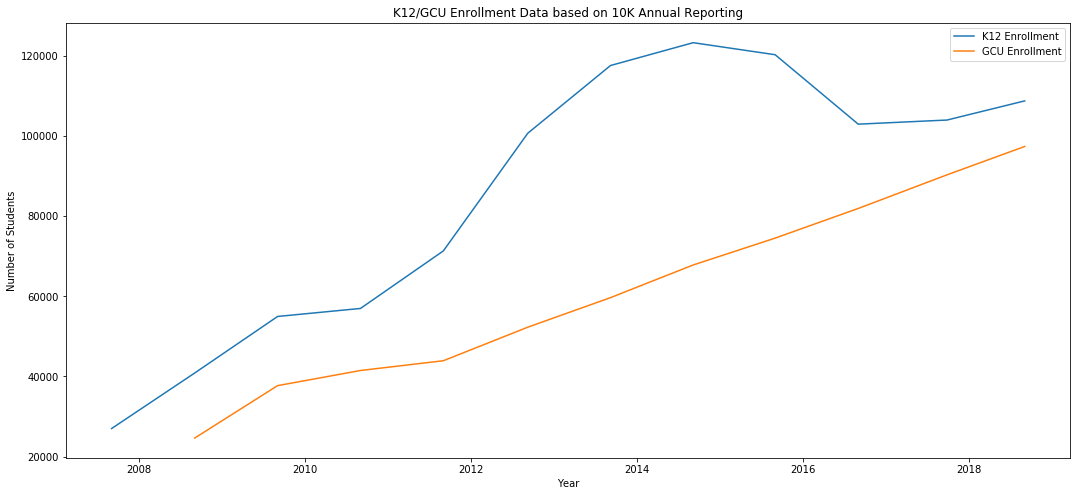

In [72]:
plt.figure(figsize=(15,10))
plt.subplots(1,sharex = True)
plt.plot(K12_df.Date, K12_df.Enrollment,label='K12 Enrollment')
plt.plot(GCU_df.Date, GCU_df.Enrollment,label='GCU Enrollment')
#plt.plot(stockEducationdf.Date, stockEducationdf.SecStudents)
plt.title("K12/GCU Enrollment Data based on 10K Annual Reporting")
plt.xlabel("Year")
plt.ylabel("Number of Students")
plt.legend()
plt.show()

<Figure size 1080x720 with 0 Axes>

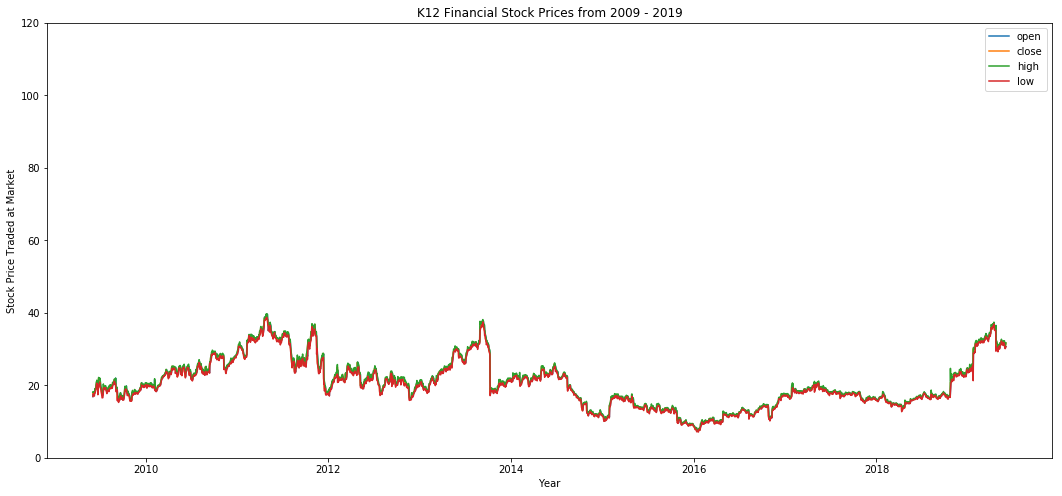

<Figure size 1080x720 with 0 Axes>

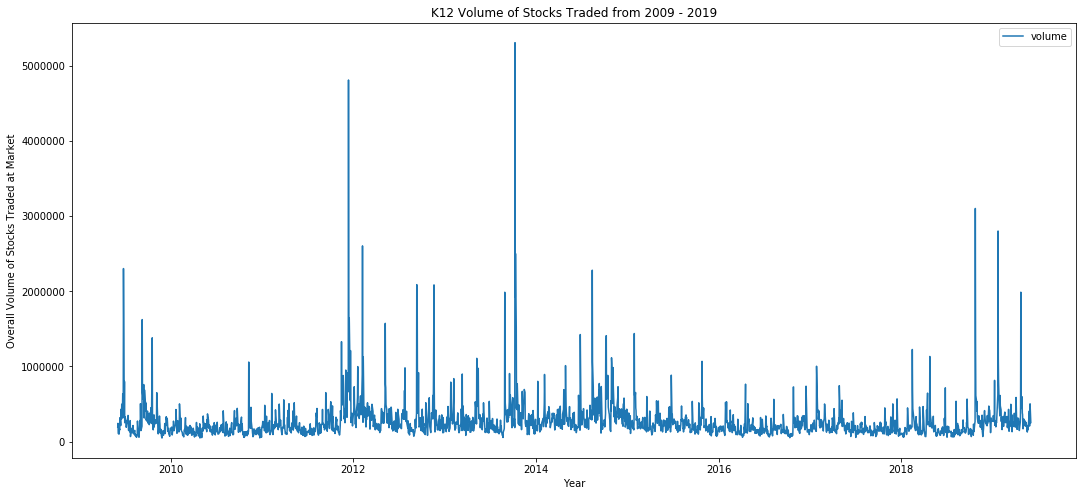

In [71]:
plt.figure(figsize=(15,10))
plt.subplots(1,sharex = True)
plt.plot(K12finance.date, K12finance.open)
plt.plot(K12finance.date, K12finance.close)
plt.plot(K12finance.date, K12finance.high)
plt.plot(K12finance.date, K12finance.low)
plt.title("K12 Financial Stock Prices from 2009 - 2019")
plt.xlabel("Year")
plt.ylabel("Stock Price Traded at Market")
plt.legend()
plt.ylim(0,120)
plt.figure(figsize=(15,10))
plt.subplots(1,sharex = True)
plt.plot(K12finance.date, K12finance.volume)
plt.title("K12 Volume of Stocks Traded from 2009 - 2019")
plt.xlabel("Year")
plt.ylabel("Overall Volume of Stocks Traded at Market")
plt.legend()
plt.show()

But when I compared the performance of student enrollment data to the overall stock trends of K12, the stock performance stayed pretty stagnant between $15-40 price/share and never really fluctuated over the past ten years. Noticing even the few dips in the stock price in the graph, you can tell those dips came right before a large issuance of stock volume because of material events within the company needing cash (i.e. new infrastructure projects, new technology builds, re-investing back to the business, etc.).

<Figure size 1080x720 with 0 Axes>

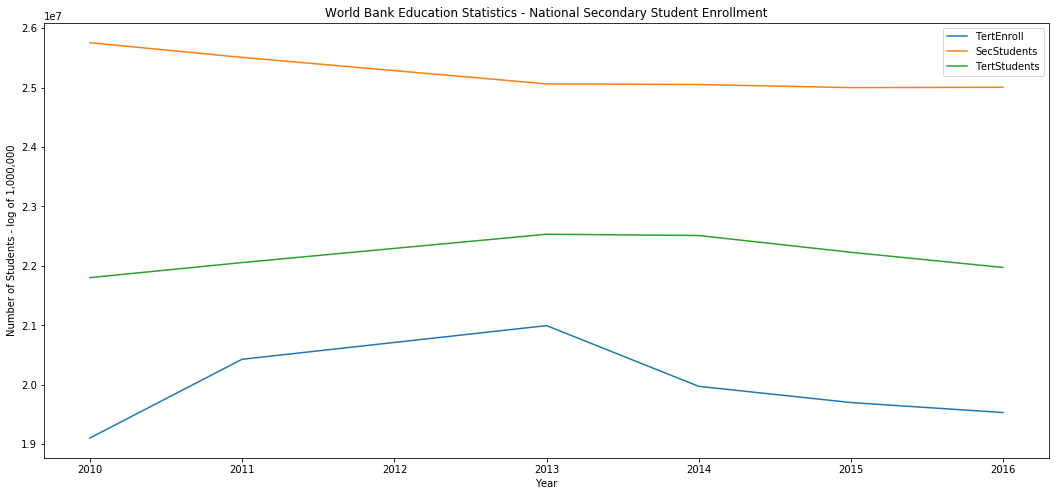

In [70]:
plt.figure(figsize=(15,10))
plt.subplots(1,sharex = True)
plt.plot(stockEducationdf.Date, stockEducationdf.TertEnroll)
plt.plot(stockEducationdf.Date, stockEducationdf.SecStudents)
plt.plot(stockEducationdf.Date, stockEducationdf.TertStudents)
plt.title("World Bank Education Statistics - National Secondary Student Enrollment")
plt.xlabel("Year")
plt.ylabel("Number of Students - log of 1,000,000")
plt.legend()
plt.show()

When I looked at the trends between students enrolled in tertiary institutions, overall tertiary student population (students who may not be enrolled at the time but listed as a “tertiary” student in their current academic standing), and secondary students, the data stayed quite flat over the last ten years with slight declines over the last five years. According to the World Bank of Education, the numbers tell an interesting story that student enrollment seems to be on the decline nationally in the United States. Assumptions about this could be wide-ranging but their general static level of not increasing or decreasing dramatically portray that the price of K12 seems to be independent of student enrollment, both on the institutional enrollment and national enrollment level.

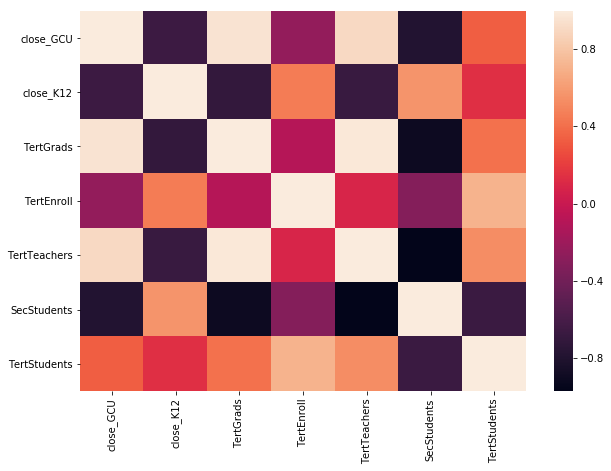

In [37]:
import seaborn as sns
corr = stockEducationdf.corr()
fig, ax = plt.subplots(figsize=(10,7))  
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Conclusion

When I looked at the heat map to quantify the correlations, the closing stock price of K12 seemed to have slight positive correlation between national student enrollment data for both secondary and tertiary students. It did not materially affect the price of K12 over the ten years which accentuates, from my perspective, the stability of the K12 as a company to generate profit despite lagging student enrollment nationally. While public secondary public education is declining, companies like K12 are achieving successful, rising year-over-year enrollment within their institution through their effective marketing and the strength of their core business – cyber-centered classrooms. Their business model isn’t focused on maintaining facilities or high expenses on the balance sheet; the value of the business is driven by their technology platform and K12 is transforming the classroom experience in 2019 in how much more students and families are resorting to this type of model. Student enrollment will continue through the 120,000+ student mark in the future and this proves to be a stable stock going forward.

The big takeaway here is that there seems to be a relationship between enrollment and stock data from the lens of a secondary education, albeit small and focused to the company itself - but let's dig this deeper.

## 2) Can we predict the stock price of these two academic institutions without the consideration of enrollment data and purely on historical data?

Back in Unit 6’s time series specialization section, ARIMA (AutoRegressive Integrated Moving Average) modeling was introduced as a method to analyze time series data in order to better understand and/or predict future points in the series using past time series performance. The unit only introduced this as a univariate approach but I was curious from the outset whether I could develop a model that could predict the “success” of these institutions (their stock price) purely through a univariate lens of past performance stock price data and into the future. As part two of this capstone, I wanted to see if a model could be created excluding the enrollment data altogether and whether this standalone model was robust or not. This would give me a way to sort of test my prediction through a pseudo-A/B testing model; see if this model works without additional variables and compare it with one that does.

When plotting the stock price performance data between GCU and K12 together, GCU’s stock price changed dramatically over the past ten years, trading at 20 USD/share to now almost 120 USD/share. The unpredictable volatility of the stock price proves to be weary from a prediction perspective but promising to the value of their shareholders – GCU is an extremely successful company and has grown tremendously in their overall valuation to the market over the past 10 years. The high spikes in trade volume show critical points in their 10-year window where they issued stock to re-invest and put money back into the school and overall looks to be a very healthy company in the education technology space.

<Figure size 1080x720 with 0 Axes>

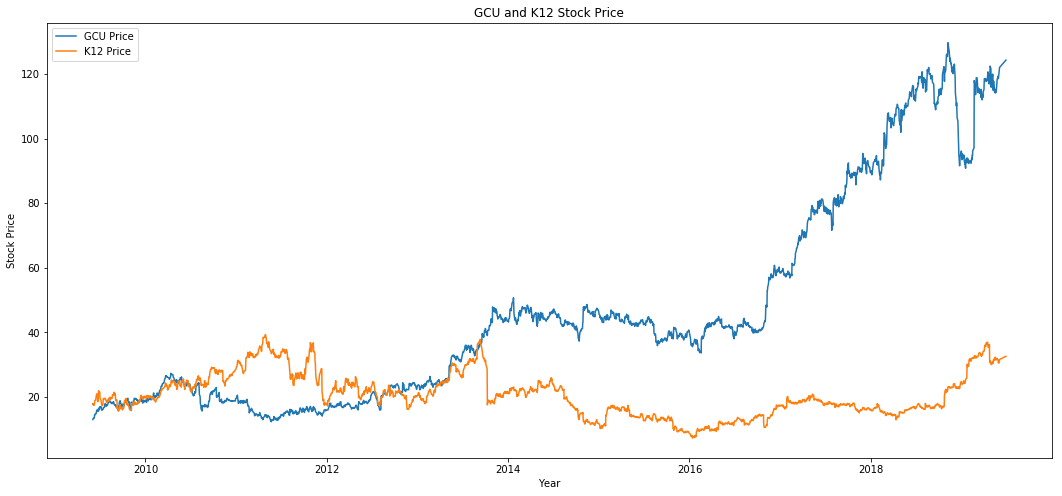

In [73]:
plt.figure(figsize=(15,10))
plt.subplots(1,sharex = True)
plt.plot(GCUdf.Date, GCUdf.close_GCU,label="GCU Price")
plt.plot(K12df.Date, K12df.close_K12,label="K12 Price")
plt.title("GCU and K12 Stock Price")
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

<Figure size 1080x720 with 0 Axes>

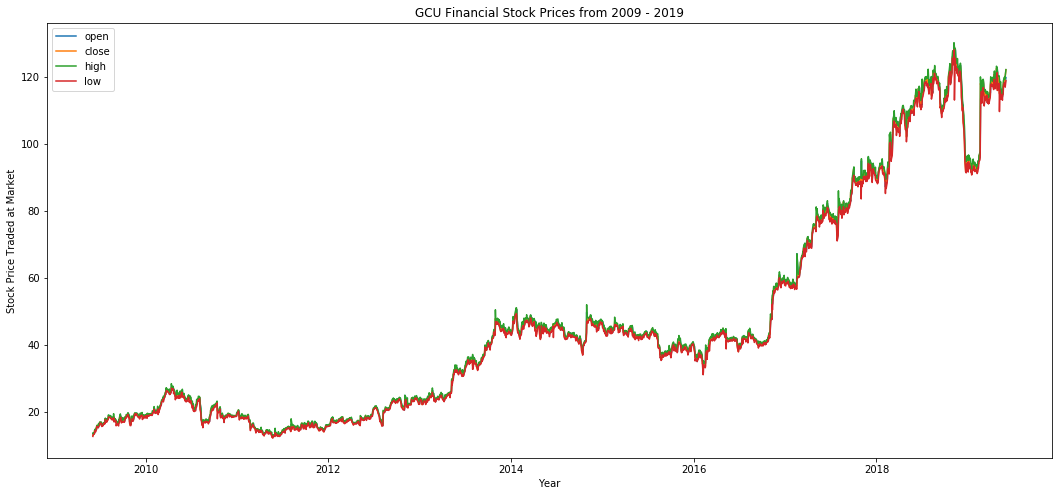

<Figure size 1080x720 with 0 Axes>

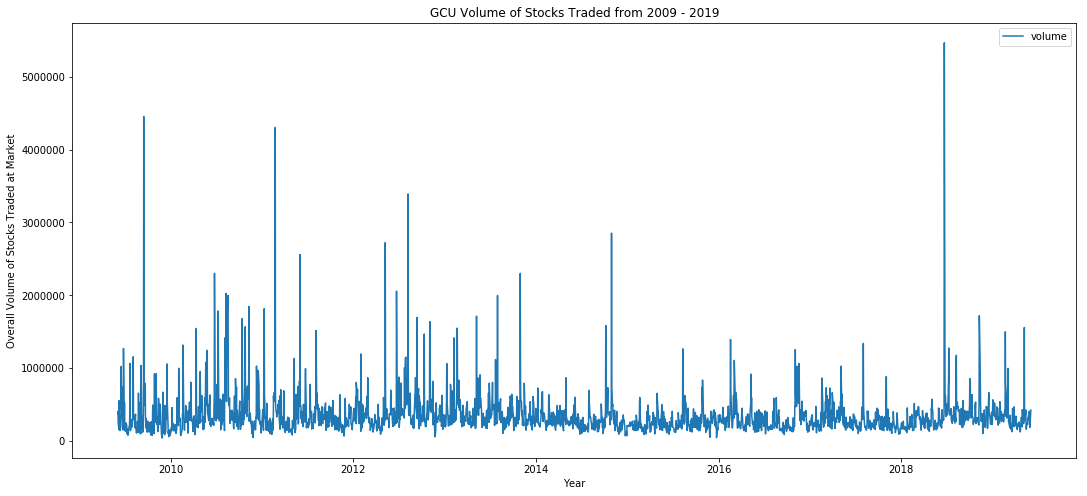

In [69]:
plt.figure(figsize=(15,10))
plt.subplots(1,sharex = True)
plt.plot(GCUfinance.date, GCUfinance.open)
plt.plot(GCUfinance.date, GCUfinance.close)
plt.plot(GCUfinance.date, GCUfinance.high)
plt.plot(GCUfinance.date, GCUfinance.low)
plt.title("GCU Financial Stock Prices from 2009 - 2019")
plt.xlabel("Year")
plt.ylabel("Stock Price Traded at Market")
plt.legend()
plt.figure(figsize=(15,10))
plt.subplots(1,sharex = True)
plt.plot(GCUfinance.date, GCUfinance.volume)
plt.title("GCU Volume of Stocks Traded from 2009 - 2019")
plt.xlabel("Year")
plt.ylabel("Overall Volume of Stocks Traded at Market")
plt.legend()
plt.show()

#### Seasonal Decomposition Graph

I plotted a seasonal decomposition plot graph to notice the observed, trend, seasonality, and residuals of the data between GCU and K12. The observed and trend graphs seem to be pretty similar which show no consistent trends in the data; the volatility of the seasonal graph shows me that there were no seasonal trends within the stock price data. This makes sense as investor sentiment wouldn’t lean too much one way or the other depending on a specific time of the year. Although school calendar years are “seasonal”, investors are putting money into the strength of the company’s fundamentals and seasonal trends won’t necessarily affect this perspective.
 
Residuals graph tell us that when values are close to zero, it suggests no bias in the forecasts whereas positive and negative values suggest a positive or negative bias in the future forecasting that is to be made by the data. Although the data hovers pretty close to the 0 mark, it isn’t a true flat zero and there are fluctuations when stock price dips with volumes of shares being sold at certain points in time. Through this ARIMA modeling we are going to see some bias in its projections as there seems to be bias consistent through time series projection. 

In [40]:
GCUdf.index = pd.DatetimeIndex(freq="b",start='2009-06-03 00:00:00',periods=2518)
K12df.index = pd.DatetimeIndex(freq="b",start='2009-06-03 00:00:00',periods=2518)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


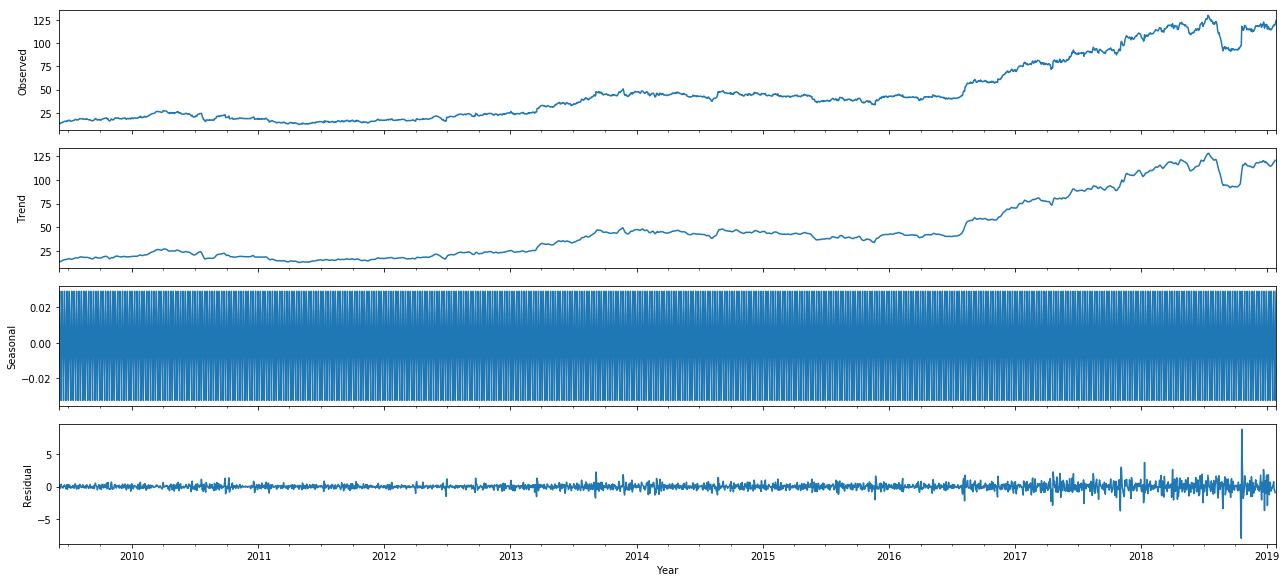

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decompositionGCU = sm.tsa.seasonal_decompose(GCUdf.close_GCU)
decompositionGCU.plot()
plt.xlabel("Year")
plt.show()

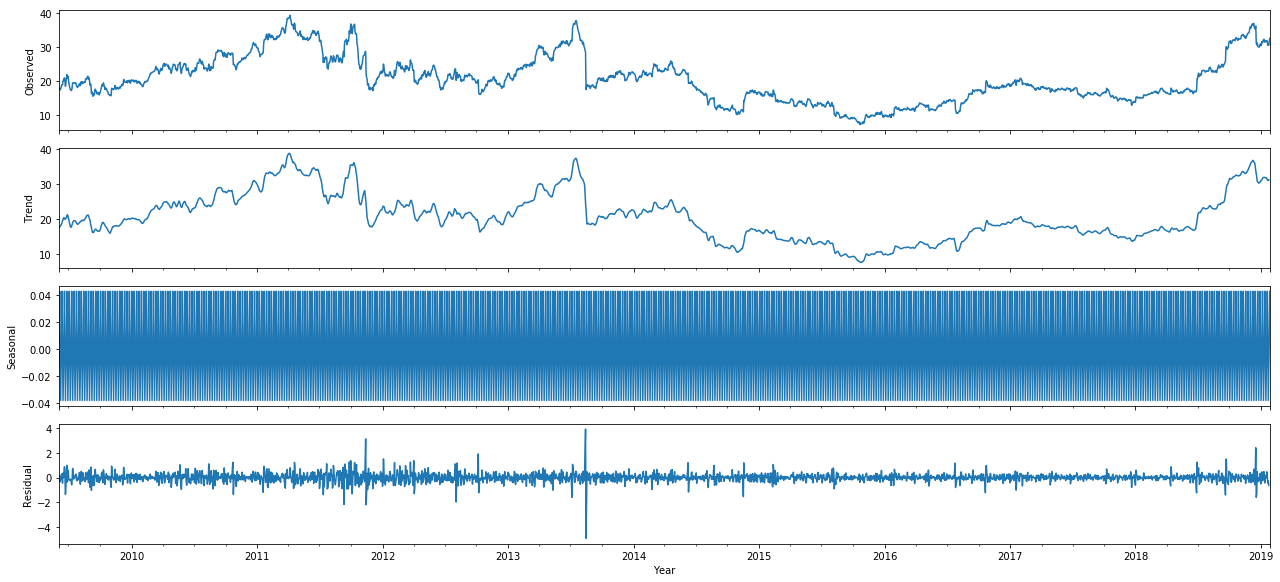

In [42]:
rcParams['figure.figsize'] = 18, 8
decompositionK12 = sm.tsa.seasonal_decompose(K12df.close_K12)
decompositionK12.plot()
plt.xlabel("Year")
plt.show()

#### ADF Stationarity Tests

ADF Stationarity Tests show with a high p-value that the data in the time series is highly volatile and shows no levels of seasonality trends or stable measures of consistency. The stock price for GCU shows a high ADF statistic meaning the model can fail to reject the null hypothesis and accept that the time series data is non stationary and highly inconsistent in its trends.

The low ADF Stationary test for K12 stock price, despite a higher P-Value, means we can accept to reject the null hypothesis and that time series data is slightly stationary. This makes sense because the K12 stock price isn’t as fluctuating as the GCU stock price and is a bit more “stable” than the upswing of GCU prices.

In [43]:
resultGCU = adfuller(GCUdf.close_GCU)
print('ADF Statistic for GCU Closing Stock Price: %f' % resultGCU[0])
print('p-value: %f' % resultGCU[1])

ADF Statistic for GCU Closing Stock Price: 0.899404
p-value: 0.993083


In [44]:
resultK12 = adfuller(K12df.close_K12)
print('ADF Statistic for K12 Closing Stock Price: %f' % resultK12[0])
print('p-value: %f' % resultK12[1])

ADF Statistic for K12 Closing Stock Price: -2.410103
p-value: 0.138905


#### Auto Arima - Finding Optimal AIC

P,D,Q are the three distinct integers used to parametrize ARIMA models.

P = autoregressive part of the model which helps incorporate effect of past values into the model.
D = integrated part of the model that incorporates amounts of differencing to apply to the time series in a forward looking projection.
Q = moving average part of the model that allows us to set the error of our model in a linear combination of error values observed at previous time points in the past.

The function is aiming to find the lowest AIC (Akaike Information Criterion) score because we want to find how well a model fits the data taking into account the complexity of the model – a model that fits the data well with lots of features will be assigned a large AIC score than a model that uses fewer features to achieve the same goodness of fit so low AIC is what we strive for. The auto ARIMA function in Python helps me generate the lowest AIC score without having to manually run individual tests like shown in Unit 6. I’ll use this approach for GCU and K12 respectively to find the best AIC score.

In [45]:
# Create Training and Test
trainGCU = GCUdf.close_GCU[:1889]
testGCU = GCUdf.close_GCU[1889:]
trainK12 = K12df.close_K12[:1889]
testK12 = K12df.close_K12[1889:]

In [46]:
modelGCU = pm.auto_arima(GCUdf.close_GCU, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(modelGCU.summary())

Fit ARIMA: order=(1, 1, 1); AIC=6880.269, BIC=6903.592, Fit time=0.276 seconds
Fit ARIMA: order=(0, 1, 0); AIC=6877.895, BIC=6889.557, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=6879.231, BIC=6896.724, Fit time=0.019 seconds
Fit ARIMA: order=(0, 1, 1); AIC=6879.217, BIC=6896.709, Fit time=0.018 seconds
Total fit time: 0.322 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2517
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3436.948
Method:                           css   S.D. of innovations              0.948
Date:                Fri, 28 Jun 2019   AIC                           6877.895
Time:                        09:02:46   BIC                           6889.557
Sample:                             1   HQIC                          6882.127
                                                                              
                 coef 

#### Plot Diagnostics

K12 (plot diagnostics for K12 is shown a bit further below) shows more normally distributed values than GCU prices which shows first off that the stock price prediction of GCU will be difficult to gage. GCU’s standardized residual graphs tell me that the ARIMA model is learning through a time series dataset that has small bias in training data set (first 75% of the data) but drastic bias and residuals near my test data set (the latter 25%). The predictive range of stock prices the ARIMA model will look at for the future will be influenced by the small bias encountered in the training set - but in actuality there was great volatility in the latter 25% so the prediction capability, although robust in theory, never panned out well in actuality. Both datasets exemplify poor normally distributed data so the data does not seem all too friendly from a statistical standpoint.
 
The QQ plots on the bottom left shows that the ordered distribution of residuals (blue dots) follows a parabolic trend of the samples taken from a standard normal distribution with N(0, 1). The fact that the red line does not match the blue lines in large part again confirms that data is not normally distributed and historical stock price volatility.

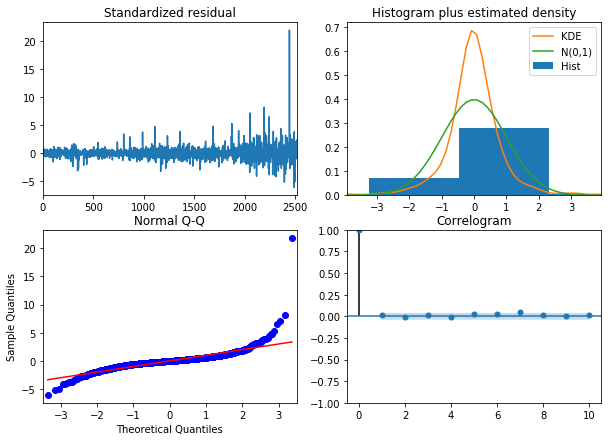

In [47]:
modelGCU.plot_diagnostics(figsize=(10,7))
plt.show()

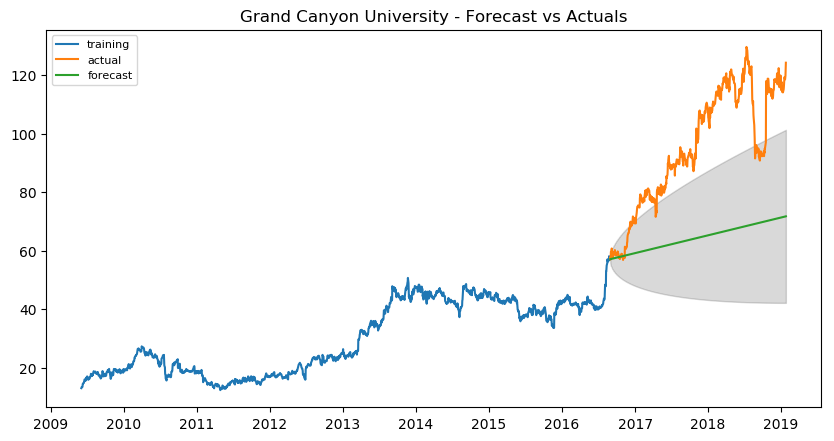

In [48]:
#629 - 25% mark for ARIMA
# Build Model
ARIMA_modelGCU = ARIMA(trainGCU, order=(0,1,0))  
fittedGCU = ARIMA_modelGCU.fit(disp=-1)  

# Forecast
fcGCU, seGCU, confGCU = fittedGCU.forecast(629, alpha=0.05)  # 95% conf

# Make as pandas series
fc_seriesGCU = pd.Series(fcGCU, index=testGCU.index)
lower_seriesGCU = pd.Series(confGCU[:, 0], index=testGCU.index)
upper_seriesGCU = pd.Series(confGCU[:, 1], index=testGCU.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(trainGCU, label='training')
plt.plot(testGCU, label='actual')
plt.plot(fc_seriesGCU, label='forecast')
plt.fill_between(lower_seriesGCU.index, lower_seriesGCU, upper_seriesGCU, 
                 color='k', alpha=.15)
plt.title('Grand Canyon University - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
modelK12 = pm.auto_arima(K12df.close_K12, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(modelK12.summary())

Fit ARIMA: order=(1, 1, 1); AIC=4668.898, BIC=4692.221, Fit time=0.230 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4673.536, BIC=4685.198, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4672.198, BIC=4689.691, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4672.247, BIC=4689.740, Fit time=0.025 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4670.652, BIC=4699.806, Fit time=0.275 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.757 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2517
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2330.449
Method:                       css-mle   S.D. of innovations              0.611
Date:                Fri, 28 Jun 2019   AIC                           4668.898
Time:                        09:02:48   BIC   

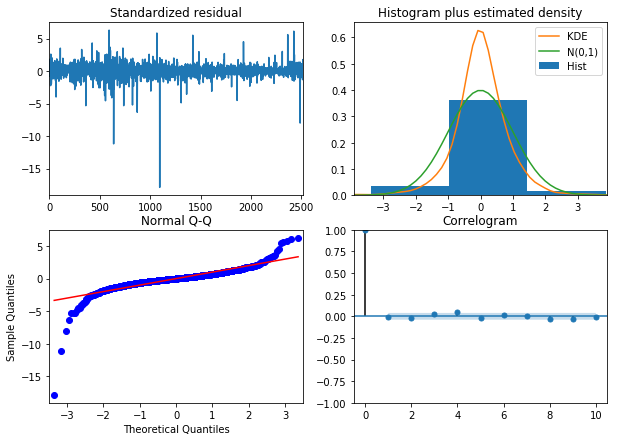

In [50]:
modelK12.plot_diagnostics(figsize=(10,7))
plt.show()

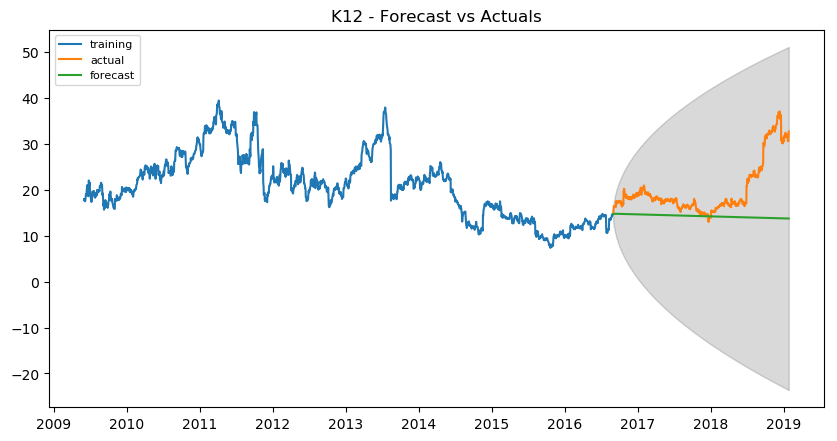

In [51]:
#629 - 25% mark for ARIMA
# Build Model
ARIMA_modelK12 = ARIMA(trainK12, order=(1,1,1))  
fittedK12 = ARIMA_modelK12.fit(disp=-1)  

# Forecast
fcK12, seK12, confK12 = fittedK12.forecast(629, alpha=0.05)  # 95% conf

# Make as pandas series
fc_seriesK12 = pd.Series(fcK12, index=testK12.index)
lower_seriesK12 = pd.Series(confK12[:, 0], index=testK12.index)
upper_seriesK12 = pd.Series(confK12[:, 1], index=testK12.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(trainK12, label='training')
plt.plot(testK12, label='actual')
plt.plot(fc_seriesK12, label='forecast')
plt.fill_between(lower_seriesK12.index, lower_seriesK12, upper_seriesK12, 
                 color='k', alpha=.15)
plt.title('K12 - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Mean Absolute Percentage Error (MAPE) shows 0.29 for the GCU model and .24 for the K12 model which are not very strong accuracy numbers for both ARIMA models. 

In [52]:
## GCU MODEL
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acfGCU = acf(fcGCU-testGCU)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acfGCU':acfGCU, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fcGCU, testGCU.values)

{'mape': 0.2977565582824608,
 'me': -30.707790732531542,
 'mae': 30.730416503866188,
 'mpe': -0.2973627506394804,
 'rmse': 34.79483543107784,
 'acfGCU': 0.991196509716407,
 'corr': 0.8892695971648542,
 'minmax': 0.29775425058557503}

In [53]:
### K12 MODEL
def forecast_accuracy1(forecast1, actual1):
    mape1 = np.mean(np.abs(forecast1 - actual1)/np.abs(actual1))  # MAPE
    me1= np.mean(forecast1 - actual1)             # ME
    mae1 = np.mean(np.abs(forecast1 - actual1))    # MAE
    mpe1 = np.mean((forecast1 - actual1)/actual1)   # MPE
    rmse1 = np.mean((forecast1 - actual1)**2)**.5  # RMSE
    corr1 = np.corrcoef(forecast1, actual1)[0,1]   # corr
    mins1 = np.amin(np.hstack([forecast1[:,None], 
                              actual1[:,None]]), axis=1)
    maxs1 = np.amax(np.hstack([forecast1[:,None], 
                              actual1[:,None]]), axis=1)
    minmax1 = 1 - np.mean(mins1/maxs1)             # minmax
    acfK12 = acf(fcK12-testK12)[1]                      # ACF1
    return({'mape':mape1, 'me':me1, 'mae': mae1, 
            'mpe': mpe1, 'rmse':rmse1, 'acfK12':acfK12, 
            'corr':corr1, 'minmax':minmax1})

forecast_accuracy1(fcK12, testK12.values)

{'mape': 0.24143460969328995,
 'me': -5.729557042034238,
 'mae': 5.742021293828014,
 'mpe': -0.2405118630505522,
 'rmse': 8.223037079993466,
 'acfK12': 0.9922247398257569,
 'corr': -0.6248833611677602,
 'minmax': 0.24141277529052863}

### Conclusion

GCU model’s p-value is seemingly not bad (less than 0.05) so the model tends to believe in its training/test data splits that it’ll behave in some way given its understanding of what has happened in the past. But when you apply the test data set of the last 25% of the data into the model, we see that in actuality the stock price in reality went way above expectation. This confirms the general uncertainty of stock price prediction with historical stock data – it is a massively difficult task to do without understanding more variables and how the data will work. K12’s ARIMA model projects a pretty flat expectation but again like GCU’s model, the stock price in reality went way above expectation. The grey forecasting as well shows the confidence interval that’s either way too big in its predictive range and ultimately is unrepresentative of what could happen in reality (prices also cannot go below 0).

I conclude here then using ARIMA modeling for stock price prediction, using historical stock price, as being quite a difficult and challenging task. If the stock price does not fluctuate between over a wide data range the time period you are analyzing, ARIMA modeling seems to fit within the forecasted range, similar to K12. However for instances like GCU where stock prices spike drastically - especially with noticeable differences between training and test data splits - the predicted data can be very different from what actually happens. I could foresee ways where this type of modeling could align itself with short term predictions that do not rely on deep historic data, but all in all stock prediction based on previous stock performance simply is difficult.
 
But clearly this isn’t enough – what if we can use a multivariate approach to look at stock prices with one extra variable as an input?

## 3) Can we take a multivariate approach towards time-series modeling to see if we can predict stock prices based on reported enrollment data?

I notice right away that the NSCH tertiary enrollment data in for-profit universities, > 25 years old enrollment, 18-24 enrollment all trended downwards over the last ten years while GCU stock price rose. There’s an inverse relationship that’s happening with national enrollment data and GCU stock data so I instead conducted just one LSTM (explained later) model that looked at GCU enrollment data, GCU stock price on the NASDAQ, and plotting forward the postiive trajection together in a Long Short Term Memory model (Recurrent Neural Networks). This model would show me within a certain confidence if we had enrollment data how we could apply this to an LSTM model going forward.

<Figure size 1296x576 with 0 Axes>

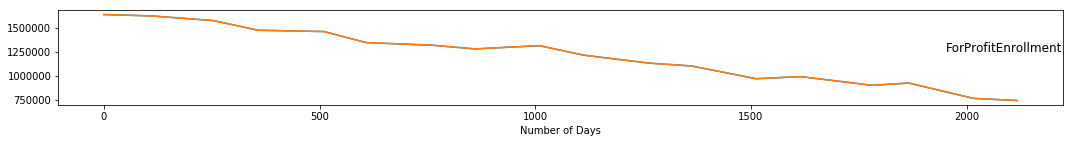

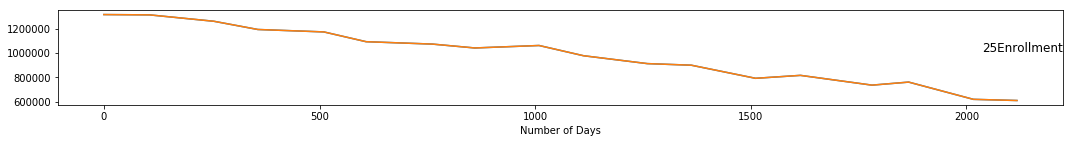

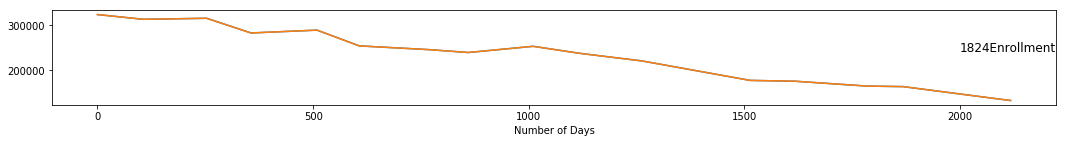

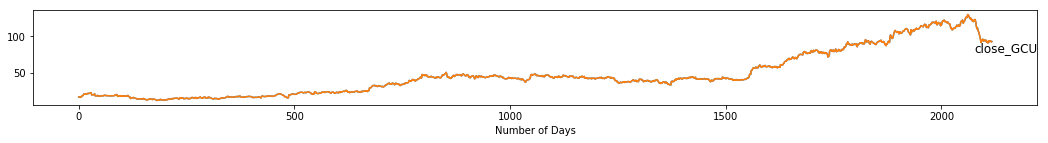

In [54]:
GCUvalues = GCUvariabledf.values
groups = [1, 2, 3, 4]
i = 1
plt.figure()
for group in groups:
	plt.subplots(1,sharex = True)
	plt.subplot(len(groups), 1, i)
	plt.plot(GCUvalues[:, group])
	plt.title(GCUvariabledf.columns[group], y=0.5, loc='right')
	plt.xlabel("Number of Days")
	plt.plot(GCUvalues[:, group])
	i += 1
plt.show()

#### Long-Short Term Memory Model - what is this?

I had to go a little outside of the course to find a time series modeling that was multivariate, an approach where I could input, match, and correlate enrollment data against the closing stock price of Grand Canyon University, and fall within close confidence intervals to predict this against train/test splits. I found up until this point enrollment data had some bias towards educational stock price.
 
LSTM Modeling (Long Short-Term Memory) is an unsupervised time-series modeling technique practiced in the machine learning community that functions through the principle of Recurrent Neural Networks. In a conventional, simple machine learning model for stock price data, the test cases for artificial neural network are considered to be independent and when fitting the model for a particular day, there is no real consideration for stock prices on previous days. The dependency on time is achieved through Recurrent Neural Networks.
 
Recurrent Neural Networks is an unsupervised learning technique that has two sources of inputs, the present and the recent past, which both combine to determine how they respond to new data. An example would be a news channel team covering a crime story. A story like this is dependent on facts, evidence, and statements of many people and consequentially when a new event occurs you perceive your predictions based on the facts, evidence, and statements of people you inherited from your collection efforts through the data. Recurrent Network models are effective because of how that sequential information is preserved and deemed as non-independent; they are looped within the network’s hidden state and they deposit that learned memory in the past to project into the future.

Our LSTM model will flow our enrollment data information through a mechanism known as cell states so that our LSTM model’s recurrent networks will selectively remember or forget things. In this case we are really only looking at enrollment data and closing stock price so there will not be much that the model will forget. The principle of this model is a rough sketch to how this type of model can be leveraged in considering how more variables could better enhance the robustness of this LSTM model and predicting stock price.

In [55]:
input_feature = GCUniStock.iloc[:,0:2].values
input_data = input_feature

In [56]:
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])

<Figure size 1080x720 with 0 Axes>

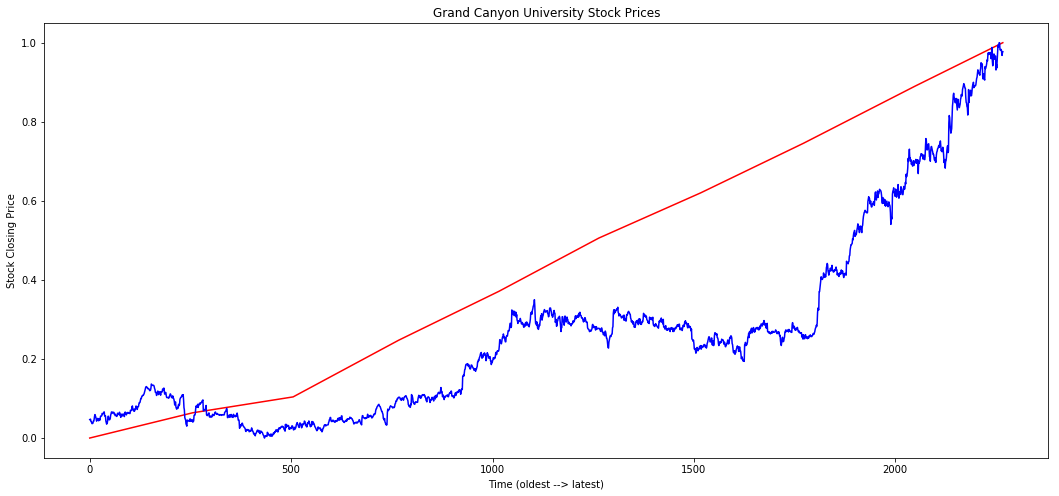

In [57]:
plt.figure(figsize=(15,10))
plt.subplots(1,sharex=True)
plt.plot(input_feature[:,0], color='red')
plt.title("Grand Canyon University Enrollment")
plt.xlabel("Time (oldest --> latest)")
plt.ylabel("Yearly Enrollment")
plt.plot(input_feature[:,1], color='blue')
plt.title("Grand Canyon University Stock Prices")
plt.xlabel("Time (oldest --> latest)")
plt.ylabel("Stock Closing Price")
plt.show()

GCU enrollment data seems to trend positively in the same direction as its stock which gives some interesting sentiment that this should affect the stock price in some way. Higher enrollment leads to greater revenue, more alumni donations, and deeper established marketable brand image as the success of these institutions will spread via word of mouth than anything else.


In [58]:
lookback= 50

test_size=int(.3 * len(GCUniStock))
xGC = []
yGC = []
for i in range(len(GCUniStock)-lookback-1):
    t1 = []
    for j in range(0,lookback):
        
        t1.append(input_data[[(i+j)], :])
    xGC.append(t1)
    yGC.append(input_data[i+ lookback,1])

In [59]:
xGC, yGC= np.array(xGC), np.array(yGC)
xGC_test = xGC[:test_size+lookback]

xGC = xGC.reshape(xGC.shape[0],lookback, 2)
xGC_test = xGC_test.reshape(xGC_test.shape[0],lookback, 2)
print(xGC.shape)
print(xGC_test.shape)


(2217, 50, 2)
(730, 50, 2)


In [60]:
modelGC = Sequential()
modelGC.add(LSTM(units=30, return_sequences= True, input_shape=(xGC.shape[1],2)))
modelGC.add(LSTM(units=30, return_sequences=True))
modelGC.add(LSTM(units=30))
modelGC.add(Dense(units=1))
modelGC.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [61]:
modelGC.compile(optimizer='adam', loss='mean_squared_error')
modelGC.fit(xGC, yGC, epochs=50, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2217/2217 [==============================] - 6s 3ms/step - loss: 0.0134
Epoch 2/50
2217/2217 [==============================] - 3s 1ms/step - loss: 5.6194e-04
Epoch 3/50
2217/2217 [==============================] - 3s 1ms/step - loss: 4.4287e-04
Epoch 4/50
2217/2217 [==============================] - 3s 1ms/step - loss: 4.3730e-04
Epoch 5/50
2217/2217 [==============================] - 3s 1ms/step - loss: 4.3407e-04
Epoch 6/50
2217/2217 [==============================] - 3s 1ms/step - loss: 3.8073e-04
Epoch 7/50
2217/2217 [==============================] - 3s 1ms/step - loss: 3.9363e-04
Epoch 8/50
2217/2217 [==============================] - 3s 1ms/step - loss: 3.5996e-04
Epoch 9/50
2217/2217 [==============================] - 3s 1ms/step - loss: 3.5059e-04
Epoch 10/50
2217/2217 [==============================] - 3s 1ms/step - loss: 3.7407e-04
Epoch 11/50
2217/2217 [==============================] - 3s 1ms/step - loss: 3.3591e-

In [62]:
GCpredicted_value= modelGC.predict(xGC_test)

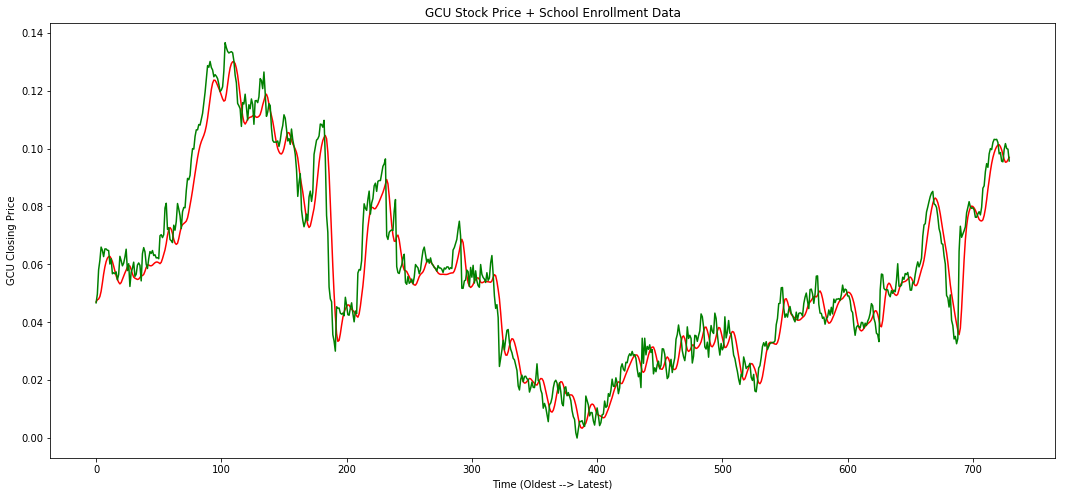

In [63]:
plt.plot(GCpredicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("GCU Stock Price + School Enrollment Data")
plt.xlabel("Time (Oldest --> Latest)")
plt.ylabel("GCU Closing Price")
plt.show()


#### Conclusion - LSTM Model Analysis

When I split the training and test splits within GCU, the predicted red line seems to be in line with GCU closing price data! The power of LSTM modeling is showing that although it is not a perfect snug fit to the real stock price, the enrollment data has some positive influence to what is actually happening in reality. The trend of enrollment data contributes quite positively to stock price prediction and LSTM modeling can be leveraged in a way to predict stock prices.

Imagining what more data we could add to this model – student/teacher ratios, graduation rates, job placement percentages, distribution of degrees, etc. – this model might be even more robust than with just enrollment data. This LSTM model can be an interesting perspective to look at general, holistic stock prediction – the enrollment data is interpolated but the principle of recurrent neural networks is showing the powerful prediction capability this model has not just for Grand Canyon University but possibly for other stocks as well.

I believe the model is best served with more variables but also with slight scrutiny in understanding that stock price prediction is ultimately also very difficult to project. As an example, the University of Phoenix – once a leading for-profit university – shut down because of fraudulent funding practices towards the US government and a lawsuit ruined their reputation. This led to them going private and closing their publicly traded stock altogether. Events like this are hard to predict but in a short term basis, I think there are ways LSTM modeling can show effectively what predictions could look like by having multiple variables influencing the y-variable outcome.

## What can we do about this? How can we apply what we learn to go forward?

My conclusion will be left with a bit of a “so-what”. In a forward-looking type of model, I’d be curious to see if my model could take the same principles we learned throughout the course and apply to this previously shown LSTM model. What if we could predict, using ARIMA modeling techniques, the enrollment data of Grand Canyon University, find within a certain range of data what that data could potentially look like and cast it forward in time predicting stock prices?

Let's try this by doing ARIMA modeling for GCU enrollment data and see if we can find some range of data we can project to look at forward enrollment. We see that the ADF statistic for enrollment data (that is interpolated) has a high ADF which shows the non-stationary aspect of this time series data.

In [64]:
resultGCUEnroll = adfuller(GCUEnrollARIMA.Enrollment)
print('ADF Statistic for Grand Canyon Enrollment: %f' % resultGCUEnroll[0])
print('p-value: %f' % resultGCUEnroll[1])

ADF Statistic for Grand Canyon Enrollment: 0.559462
p-value: 0.986573


In [65]:
EnrollARIMA = pm.auto_arima(GCUEnrollARIMA.Enrollment, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(EnrollARIMA.summary())

Fit ARIMA: order=(1, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0); AIC=3501.620, BIC=3513.071, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3503.620, BIC=3520.797, Fit time=0.025 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3503.620, BIC=3520.797, Fit time=0.023 seconds
Total fit time: 0.147 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 2266
Model:                 ARIMA(0, 2, 0)   Log Likelihood               -1748.810
Method:                           css   S.D. of innovations              0.524
Date:                Fri, 28 Jun 2019   AIC                           3501.620
Time:                        09:05:33   BIC                           3513.071
Sample:                             2   HQIC                          3505.798
                                                                              
                 coef    std err  

In [66]:
trainGCUEnroll = GCUEnrollARIMA.Enrollment[:1701]
testGCUEnroll = GCUEnrollARIMA.Enrollment[1702:]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


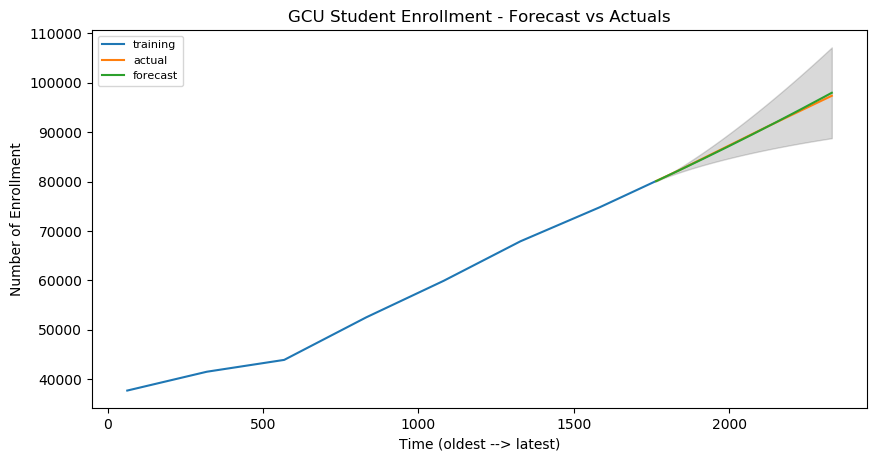

In [67]:
#566 - 25% mark for ARIMA
# Build Model
# model = ARIMA(train, order=(3,2,1))  
ARIMA_GCUEnroll = ARIMA(trainGCUEnroll, order=(0, 2, 0))
fittedGCUEnroll = ARIMA_GCUEnroll.fit(disp=-1)  

# Forecast
fcGCUEnroll, seGCUEnroll, confGCUEnroll = fittedGCUEnroll.forecast(566, alpha=0.05)  # 95% conf

# Make as pandas series
fc_seriesGCUEnroll = pd.Series(fcGCUEnroll, index=testGCUEnroll.index)
lower_seriesGCUEnroll = pd.Series(confGCUEnroll[:, 0], index=testGCUEnroll.index)
upper_seriesGCUEnroll = pd.Series(confGCUEnroll[:, 1], index=testGCUEnroll.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(trainGCUEnroll, label='training')
plt.plot(testGCUEnroll, label='actual')
plt.plot(fc_seriesGCUEnroll, label='forecast')
plt.fill_between(lower_seriesGCUEnroll.index, lower_seriesGCUEnroll, upper_seriesGCUEnroll, 
                 color='k', alpha=.15)
plt.title('GCU Student Enrollment - Forecast vs Actuals')
plt.xlabel("Time (oldest --> latest)")
plt.ylabel("Number of Enrollment")
plt.legend(loc='upper left', fontsize=8)
plt.show()

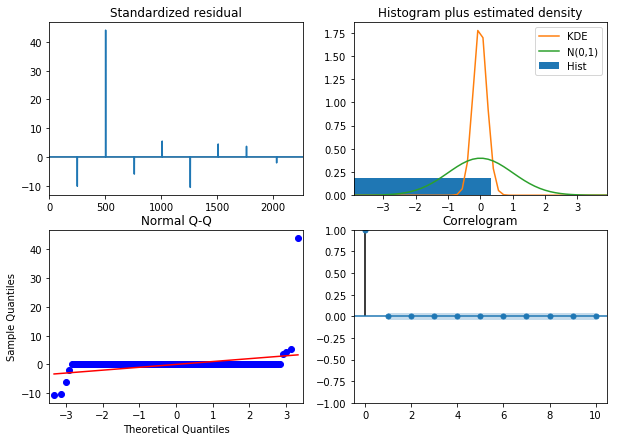

In [68]:
EnrollARIMA.plot_diagnostics(figsize=(10,7))
plt.show()

Using some of the same techinques shown previously with Grand Canyon University and K12, using ARIMA modeling to project through enrollment data is shown through this graph above. The data seems here to be a bit underwhelming. The QQ plot on the bottom left shows the ordered distribution not following much of a trend and the data has big swings in residuals. This may due to the interpolated nature of the data but I believe the principle of this type of forward projection can help create a valuable input towards our LSTM model. The LSTM model shown earlier inherited a wealth of historical GCU data from its past stock price history but now by projecting forward with new enrollment data estimatations, our model can positively influence stock price prediction knowing what it's already learned.

## Conclusion

Stock price prediction is a difficult task – if anyone knew how to do it, many of us would be millionaires! But what this capstone proves is that techniques in machine learning show that through additional variables there are methods of incorporating a multitude of different variables together that can bolster a positive effect on the prediction of a Y-outcome.

My initial perspective going into this was to see how variables (enrollment data) correlated to a Y-outcome (stock price) and whether you could create a prediction model based on that correlated data. I attempted to test this through A/B testing techinques taught in the course by trying one model that did not have any external features, other than the Y-outcome's historic data, and one model that was multivariate and had other influences. I learned that my assumptions about correlations between enrollment data and stock price were true, but the investor sentiment that drives the purchase of these stocks comes little to what's happening nationally, in enrollment, and quite favorably towards company fundamentals, core values, and trends within the industry itself. 

A practical type of application to this type of LSTM modeling would be tailored for financial analysts in the investment world or strategy analysts for those who work for educational companies. For financial analysts - who are constantly researching company fundamentals, stock price data, weekly bond prices, etc. - we could practically see that by plugging in these types of correlated variables towards a prediction of time-series stock price data of any company of their choice, LSTM modeling might show a type of prediction worth comparing to in reality. Conversely with those who work for educational companies, we can see this model play itself with analysts who handle proprietary, classified data - i.e. student demographics, job placement percentages across industries, alumni donation rates, etc. - as a way to predict these types of related features. Techniques like Principal Components Analysis then to see correlations between the strenght of these features and then projecting this out as an input to an LSTM model might be an interesting tool and application of this product in a real-life scenario.